# Fine Tuning du model SuperPoint + LightGlue

## Importer les modèles 

In [1]:
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Force l'utilisation de Matching_LightGlue comme répertoire de base
matching_lightglue_root = Path("C:/Users/STAGE2025/Matching_LightGlue").resolve()
if str(matching_lightglue_root) not in sys.path:
    sys.path.insert(0, str(matching_lightglue_root))

import torch
import yaml 
from gluefactory.models.matchers.lightglue import LightGlue
from gluefactory_nonfree.superpoint import SuperPoint
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir='runs/experiment1')

import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import default_collate
import torch.nn.functional as F

# Supposons que les classes DataAugmentation et FloorPlanDataset sont déjà définies dans votre répertoire
from datasets.DataAugmentation import DataAugmentation  # Classe pour les augmentations
from datasets.Datasets import FloorPlanDataset  # Dataset personnalisé
from datasets.sync_augmentations import SynchronizedAugmentations

from loss_utils import normalize_descriptors, compute_consistency_loss, custom_loss, check_gradients  # Fonctions pour optimiser la fonction loss du mode auto supervisé


## Charger les modèles en mode train 

In [2]:
# Charger le fichier de configuration
with open("configs/superpoint+lightglue_Mydataset.yaml", "r") as f:
    config = yaml.safe_load(f)

# Initialiser le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger les modèles avec la configuration
extractor = SuperPoint(config["model"]["extractor"]).train().to(device)
matcher = LightGlue(config["model"]["matcher"]).train().to(device)

# Charger SuperPoint
superpoint_weights = r"C:\Users\STAGE2025\Downloads\superpoint_v1.pth"
state_dict = torch.load(superpoint_weights, map_location=device)
extractor.load_state_dict(state_dict)

# Charger LightGlue avec modification des clés
lightglue_weights = r"C:\Users\STAGE2025\Downloads\superpoint_lightglue.pth"
state_dict = torch.load(lightglue_weights, map_location=device)

# Modifier les clés du dictionnaire d'état
new_state_dict = {}
for k, v in state_dict.items():
    if 'self_attn.' in k:
        layer_num = k.split('.')[1]
        rest = '.'.join(k.split('.')[2:])
        new_k = f'transformers.{layer_num}.self_attn.{rest}'
        new_state_dict[new_k] = v
    elif 'cross_attn.' in k:
        layer_num = k.split('.')[1]
        rest = '.'.join(k.split('.')[2:])
        new_k = f'transformers.{layer_num}.cross_attn.{rest}'
        new_state_dict[new_k] = v
    else:
        new_state_dict[k] = v

# Essayer de charger les poids avec différentes options
try:
    # Option 1: Charger avec les clés modifiées
    matcher.load_state_dict(new_state_dict, strict=False)
except:
    try:
        # Option 2: Charger directement sans strict
        matcher.load_state_dict(state_dict, strict=False)
    except Exception as e:
        print(f"Erreur lors du chargement des poids: {e}")

# Vérifier les poids de SuperPoint
print("SuperPoint weights:")
for name, param in extractor.named_parameters():
    print(f"Layer: {name}, Mean: {param.data.mean().item()}, Std: {param.data.std().item()}")

# Vérifier les poids de LightGlue
print("\nLightGlue weights:")
for name, param in matcher.named_parameters():
    print(f"Layer: {name}, Mean: {param.data.mean().item()}, Std: {param.data.std().item()}")

# Vérifier si les poids ont été chargés correctement
print("\nVérification des paramètres chargés:")
print("Nombre de paramètres dans SuperPoint:", sum(p.numel() for p in extractor.parameters()))
print("Nombre de paramètres dans LightGlue:", sum(p.numel() for p in matcher.parameters()))

SuperPoint weights:
Layer: conv1a.weight, Mean: -0.04996200278401375, Std: 24.79438591003418
Layer: conv1a.bias, Mean: -0.0005103647708892822, Std: 3.128390312194824
Layer: conv1b.weight, Mean: -0.001482171704992652, Std: 0.05937820300459862
Layer: conv1b.bias, Mean: -2.1226143836975098, Std: 6.563289642333984
Layer: conv2a.weight, Mean: -0.0013311207294464111, Std: 0.056420210748910904
Layer: conv2a.bias, Mean: 0.6110613346099854, Std: 3.7401230335235596
Layer: conv2b.weight, Mean: -0.001152216107584536, Std: 0.07580942660570145
Layer: conv2b.bias, Mean: 0.14012907445430756, Std: 8.133206367492676
Layer: conv3a.weight, Mean: -0.001981099834665656, Std: 0.04230864346027374
Layer: conv3a.bias, Mean: 1.930755615234375, Std: 3.9428415298461914
Layer: conv3b.weight, Mean: -0.0020349903497844934, Std: 0.04990966618061066
Layer: conv3b.bias, Mean: 1.342414140701294, Std: 3.525167465209961
Layer: conv4a.weight, Mean: -0.0005101060378365219, Std: 0.03590106964111328
Layer: conv4a.bias, Mean: 0

## Structures des modèles 

In [3]:

## Fonction pour analyser un modèle
def analyze_model(model, name="Model"):
    print(f"\n{'='*20} {name} Analysis {'='*20}")
    
    # Afficher la structure du modèle
    print("\nStructure du modèle :")
    print(model)
    
    # Calculer le nombre de paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"\nNombre total de paramètres : {total_params:,}")
    print(f"Paramètres entraînables : {trainable_params:,}")
    print(f"Paramètres non-entraînables : {non_trainable_params:,}")
    
    # Afficher les couches et leurs états
    print("\nDétails des couches :")
    for name, param in model.named_parameters():
        print(f"Couche : {name}")
        print(f"  Shape : {param.shape}")
        print(f"  Entraînable : {param.requires_grad}")
        print(f"  Nombre de paramètres : {param.numel():,}")

# Analyser SuperPoint
analyze_model(extractor, "SuperPoint")

# Analyser LightGlue
analyze_model(matcher, "LightGlue")


==================== SuperPoint Analysis ====================

Structure du modèle :
SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_

## Geler des couches 

In [4]:
## Afficher la structure des modèles pour voir les noms des couches
print("SuperPoint structure:")
for name, param in extractor.named_parameters():
    print(f"Layer: {name}")

print("\nLightGlue structure:")
for name, param in matcher.named_parameters():
    print(f"Layer: {name}")

# Geler toutes les couches
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

# Dégeler toutes les couches
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

# Dégeler des couches spécifiques
def unfreeze_layers(model, layer_names):
    for name, param in model.named_parameters():
        if any(layer_name in name for layer_name in layer_names):
            param.requires_grad = True

# Geler tout SuperPoint
freeze_model(extractor)

# Dégeler les couches responsables des descripteurs et des points clés (SuperPoint)
unfreeze_layers(extractor, ['convDa', 'convDb'])

# Geler tout LightGlue
freeze_model(matcher)

# Dégeler les couches responsables des correspondances et des scores (LightGlue)
unfreeze_layers(matcher, ['transformers.5.','log_assignment', 'token_confidence'])

# Vérifier l'état des couches
def print_layers_status(model, model_name="Model"):
    print(f"\n{model_name} layers status:")
    for name, param in model.named_parameters():
        print(f"Layer: {name}, Trainable: {param.requires_grad}")

print_layers_status(extractor, "SuperPoint")
print_layers_status(matcher, "LightGlue")


SuperPoint structure:
Layer: conv1a.weight
Layer: conv1a.bias
Layer: conv1b.weight
Layer: conv1b.bias
Layer: conv2a.weight
Layer: conv2a.bias
Layer: conv2b.weight
Layer: conv2b.bias
Layer: conv3a.weight
Layer: conv3a.bias
Layer: conv3b.weight
Layer: conv3b.bias
Layer: conv4a.weight
Layer: conv4a.bias
Layer: conv4b.weight
Layer: conv4b.bias
Layer: convPa.weight
Layer: convPa.bias
Layer: convPb.weight
Layer: convPb.bias
Layer: convDa.weight
Layer: convDa.bias
Layer: convDb.weight
Layer: convDb.bias

LightGlue structure:
Layer: posenc.Wr.weight
Layer: transformers.0.self_attn.Wqkv.weight
Layer: transformers.0.self_attn.Wqkv.bias
Layer: transformers.0.self_attn.out_proj.weight
Layer: transformers.0.self_attn.out_proj.bias
Layer: transformers.0.self_attn.ffn.0.weight
Layer: transformers.0.self_attn.ffn.0.bias
Layer: transformers.0.self_attn.ffn.1.weight
Layer: transformers.0.self_attn.ffn.1.bias
Layer: transformers.0.self_attn.ffn.3.weight
Layer: transformers.0.self_attn.ffn.3.bias
Layer: t

In [5]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4
epochs = 300
learning_rate = 0.001


def safe_collate_fn(batch):
    filtered = []
    for sample in batch:
        try:
            if sample['keypoints0'].shape == (11, 2) and sample['keypoints1'].shape == (11, 2):
                filtered.append(sample)
        except Exception as e:
            print("Sample ignoré à cause d’une erreur:", e)
    
    if len(filtered) == 0:
        return default_collate([batch[0]])  # fallback minimal
    return default_collate(filtered)


augmentations = SynchronizedAugmentations(config={
    "random_rotation_90": True,
    "horizontal_flip": True,
    "vertical_flip": True,
    "random_zoom": True,
    "zoom_range": [0.9, 1.1],
    "random_translation": True,
    "max_translation": 30,
})

# Chemin vers le dossier contenant la base de données
base_dir = "datasets/organized_dataset/Undistorted_SfM"
augmentations = DataAugmentation(image_size=(512, 512))  # Taille des images après augmentation

# Créer une instance du Dataset personnalisé
dataset = FloorPlanDataset(
    base_dir,
    json_path=r"C:\Users\STAGE2025\Matching_LightGlue\database.json",
    augmentations=augmentations
)

# Séparation train/validation (80% train, 20% validation)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader pour l'entraînement
dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=safe_collate_fn
)

# DataLoader pour la validation
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=safe_collate_fn
)

print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(dataloader)
print(val_dataloader)

Nombre de paires d'images trouvées: 152
Nombre d'annotations trouvées: 152
✅ Mapping créé: pair1 -> pair1
✅ Mapping créé: pair2 -> pair2
✅ Mapping créé: pair3 -> pair3
✅ Mapping créé: pair4 -> pair4
✅ Mapping créé: pair5 -> pair5
✅ Mapping créé: pair6 -> pair6
✅ Mapping créé: pair7 -> pair7
✅ Mapping créé: pair8 -> pair8
✅ Mapping créé: pair9 -> pair9
✅ Mapping créé: pair10 -> pair10
✅ Mapping créé: pair11 -> pair11
✅ Mapping créé: pair12 -> pair12
✅ Mapping créé: pair13 -> pair13
✅ Mapping créé: pair14 -> pair14
✅ Mapping créé: pair15 -> pair15
✅ Mapping créé: pair16 -> pair16
✅ Mapping créé: pair17 -> pair17
✅ Mapping créé: pair18 -> pair18
✅ Mapping créé: pair19 -> pair19
✅ Mapping créé: pair20 -> pair20
✅ Mapping créé: pair21 -> pair21
✅ Mapping créé: pair22 -> pair22
✅ Mapping créé: pair23 -> pair23
✅ Mapping créé: pair24 -> pair24
✅ Mapping créé: pair25 -> pair25
✅ Mapping créé: pair26 -> pair26
✅ Mapping créé: pair27 -> pair27
✅ Mapping créé: pair28 -> pair28
✅ Mapping créé: pai

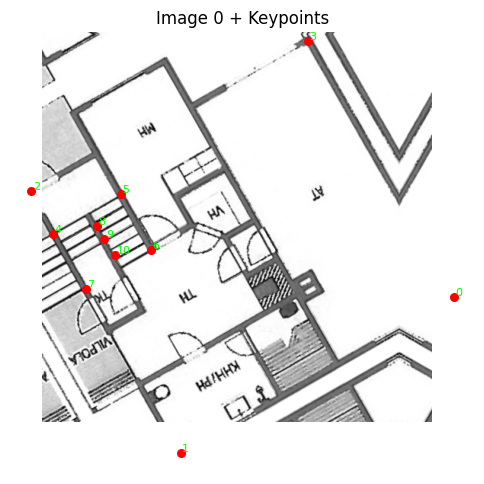

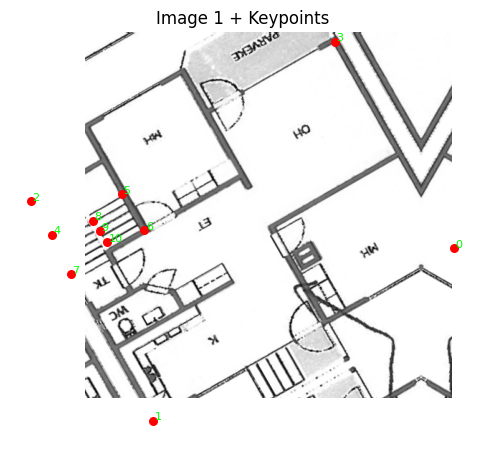

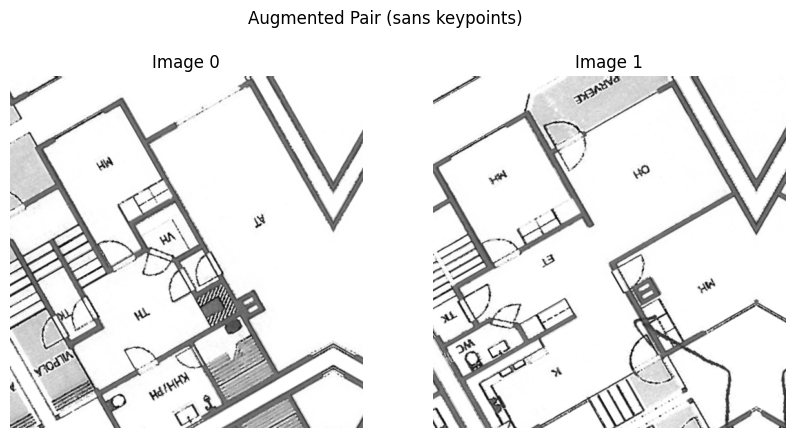

Validation après augmentation: 100%|██████████| 30/30 [00:01<00:00, 15.67it/s]


📊 Résumé des paires valides **après augmentation** :
 - Train : 122 / 122
 - Validation : 30 / 30
 - Total utilisé : 152


In [6]:
import matplotlib.pyplot as plt

idx = 43  # ou un autre indice
ann = dataset.pair_to_annotation.get(idx)
#print(f"\nAnnotation pour la paire {idx}: ", "✅ Trouvée" if ann else "❌ Manquante")


def plot_matches(img1, img2, kpts1, kpts2, matches, scores, threshold=0.1, title="Matches"):
    import matplotlib.pyplot as plt

    kpts1 = kpts1.cpu().numpy()
    kpts2 = kpts2.cpu().numpy()
    matches = matches.cpu().numpy()
    scores = scores.cpu().detach().numpy()

    valid = (matches > -1) & (scores > threshold)
    matched_kpts1 = kpts1[valid]
    matched_kpts2 = kpts2[matches[valid]]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1.squeeze().cpu().numpy(), cmap='gray')
    ax[0].scatter(matched_kpts1[:, 0], matched_kpts1[:, 1], c='r', s=30)
    ax[0].set_title("Image 0")

    ax[1].imshow(img2.squeeze().cpu().numpy(), cmap='gray')
    ax[1].scatter(matched_kpts2[:, 0], matched_kpts2[:, 1], c='b', s=30)
    ax[1].set_title("Image 1")

    plt.suptitle(title)
    plt.show()




def plot_keypoints_on_image(img, keypoints, title="Image"):
    """
    img: [1, H, W] tensor (grayscale)
    keypoints: [N, 2] tensor
    """
    img_np = img.squeeze().numpy()  # [H, W]
    kpts_np = keypoints.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap='gray')
    plt.scatter(kpts_np[:, 0], kpts_np[:, 1], c='r', s=30)
    for i, (x, y) in enumerate(kpts_np):
        plt.text(x + 2, y - 2, str(i), color='lime', fontsize=8)
    plt.title(title)
    plt.axis('off')
    plt.show()




# Exemple d’un batch depuis le dataset
sample = dataset[142]  # ou un autre index, selon le cas

# Visualisation des images + keypoints
plot_keypoints_on_image(sample['image0'], sample['keypoints0'], title="Image 0 + Keypoints")
plot_keypoints_on_image(sample['image1'], sample['keypoints1'], title="Image 1 + Keypoints")




###################################### Ajouter dernièrement pour affichage des augment et nbre de paires ###########################################
def plot_augmented_pair(sample, title="Augmented Pair (sans keypoints)"):
    img0 = sample['image0'].squeeze().numpy()
    img1 = sample['image1'].squeeze().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img0, cmap='gray')
    ax[0].set_title("Image 0")
    ax[0].axis("off")

    ax[1].imshow(img1, cmap='gray')
    ax[1].set_title("Image 1")
    ax[1].axis("off")

    plt.suptitle(title)
    plt.show()

# Affiche un exemple visuel d’une paire d’images augmentées
plot_augmented_pair(sample)

from tqdm import tqdm

def count_augmented_valid_pairs(dataset, max_samples=200):
    valid_count = 0
    total_checked = min(len(dataset), max_samples)

    for i in tqdm(range(total_checked), desc="Validation après augmentation"):
        try:
            sample = dataset[i]
            kpts0 = sample['keypoints0']
            kpts1 = sample['keypoints1']
            
            # Vérifie que tous les points sont valides (pas du padding)
            if kpts0.shape == (11, 2) and kpts1.shape == (11, 2):
                if not torch.all(kpts0 == 0) and not torch.all(kpts1 == 0):
                    valid_count += 1
        except Exception as e:
            print(f"Erreur sur l’échantillon {i} : {e}")
            continue

    return valid_count, total_checked

valid_train_aug, total_train_checked = count_augmented_valid_pairs(train_dataset)
valid_val_aug, total_val_checked = count_augmented_valid_pairs(val_dataset)

print("\n📊 Résumé des paires valides **après augmentation** :")
print(f" - Train : {valid_train_aug} / {total_train_checked}")
print(f" - Validation : {valid_val_aug} / {total_val_checked}")
print(f" - Total utilisé : {valid_train_aug + valid_val_aug}")
####################################################################################################################################################


## Ré entrainement des modèles 


=== Epoch 1/300 ===

Batch 0/31
Loss: 113.4018
Score moyen des correspondances: 0.0000

Batch 5/31
Loss: 122.4970
Score moyen des correspondances: 0.0003

Batch 15/31
Loss: 92.5718
Score moyen des correspondances: 0.0000

Batch 20/31
Loss: 80.9312
Score moyen des correspondances: 0.0176

Batch 25/31
Loss: 110.1730
Score moyen des correspondances: 0.0014

Batch 30/31
Loss: 131.8244
Score moyen des correspondances: 0.0563

Epoch 1/300, Average Loss: 109.1158
Validation Loss: 81.9422 | Validation Matching Score: 0.0492
Nouveau meilleur modèle sauvegardé (loss: 109.1158)

Entraînement terminé!
Meilleure perte: 109.1158

=== Epoch 2/300 ===


c:\Users\STAGE2025\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Batch 0/31
Loss: 128.8565
Score moyen des correspondances: 0.0207

Batch 5/31
Loss: 103.2108
Score moyen des correspondances: 0.0626

Batch 10/31
Loss: 60.0428
Score moyen des correspondances: 0.0924

Batch 15/31
Loss: 116.7665
Score moyen des correspondances: 0.0954

Batch 20/31
Loss: 98.6513
Score moyen des correspondances: 0.1697

Batch 25/31
Loss: 90.2799
Score moyen des correspondances: 0.1387

Batch 30/31
Loss: 98.9108
Score moyen des correspondances: 0.1025

Epoch 2/300, Average Loss: 95.3915
Validation Loss: 83.8768 | Validation Matching Score: 0.1324
Nouveau meilleur modèle sauvegardé (loss: 95.3915)

Entraînement terminé!
Meilleure perte: 95.3915

=== Epoch 3/300 ===

Batch 0/31
Loss: 76.7791
Score moyen des correspondances: 0.1235

Batch 5/31
Loss: 76.3158
Score moyen des correspondances: 0.1396

Batch 10/31
Loss: 91.3275
Score moyen des correspondances: 0.1001

Batch 15/31
Loss: 113.5014
Score moyen des correspondances: 0.2408

Batch 20/31
Loss: 60.0657
Score moyen des cor

c:\Users\STAGE2025\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Batch 30/31
Loss: 11.9818
Score moyen des correspondances: 0.1265

Epoch 22/300, Average Loss: 35.1930
Validation Loss: 23.1743 | Validation Matching Score: 0.1912
Nouveau meilleur modèle sauvegardé (loss: 35.1930)

Entraînement terminé!
Meilleure perte: 35.1930

=== Epoch 23/300 ===

Batch 0/31
Loss: 31.6014
Score moyen des correspondances: 0.3481

Batch 5/31
Loss: 32.0822
Score moyen des correspondances: 0.2359

Batch 10/31
Loss: 35.7659
Score moyen des correspondances: 0.4009

Batch 15/31
Loss: 34.1221
Score moyen des correspondances: 0.2695

Batch 20/31
Loss: 39.0758
Score moyen des correspondances: 0.2221

Batch 25/31
Loss: 39.0874
Score moyen des correspondances: 0.2217

Batch 30/31
Loss: 38.0295
Score moyen des correspondances: 0.3360

Epoch 23/300, Average Loss: 35.9742
Validation Loss: 26.3324 | Validation Matching Score: 0.2157

Entraînement terminé!
Meilleure perte: 35.1930

=== Epoch 24/300 ===

Batch 0/31
Loss: 31.7026
Score moyen des correspondances: 0.3132

Batch 5/31
L

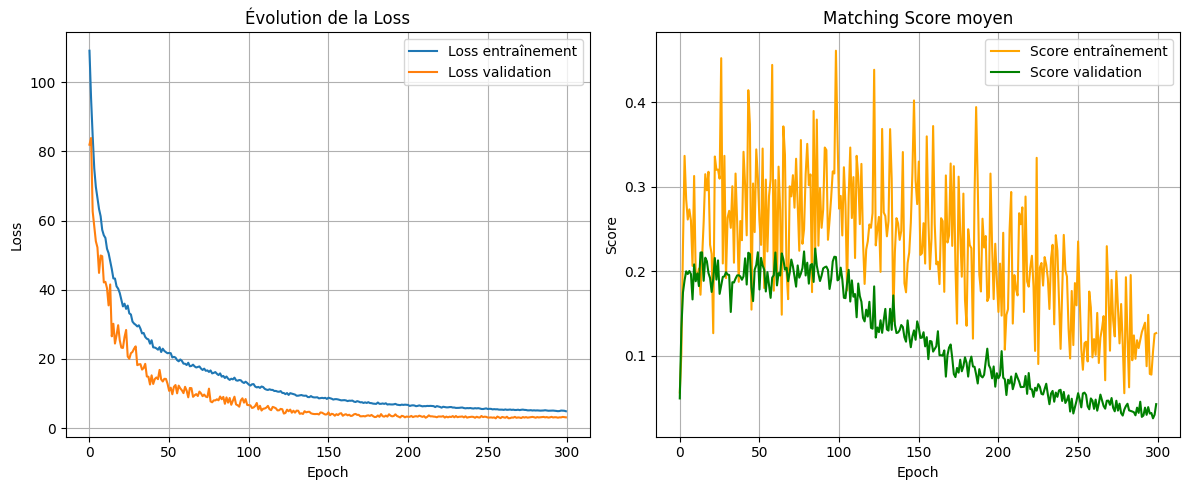

In [7]:
#Configuration de l'optimiseur et du scheduler
optimizer = optim.Adam([ {"params": extractor.parameters(), "lr": 1e-6}, {"params": matcher.parameters(), "lr": 1e-5} ], weight_decay=1e-5)

import matplotlib.pyplot as plt

def debug_plot(img, gt_pts, pred_pts, title="Debug View"):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.scatter(gt_pts[:, 0].cpu(), gt_pts[:, 1].cpu(), c='lime', label='GT', s=30)
    plt.scatter(pred_pts[:, 0].cpu(), pred_pts[:, 1].cpu(), c='red', marker='x', label='Pred', s=30)
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

scheduler = OneCycleLR(optimizer,
                       max_lr=[1e-4, 1e-3], # Pour extractor et matcher respectivement
                       epochs=epochs,
                       steps_per_epoch=len(dataloader),
                       pct_start=0.3 # Warm-up pendant 30% de l'entraînement
                         )

#Boucle d'entraînement
best_loss = float('inf') 
patience_counter = 0 
max_patience = 100

all_losses = [] ################################################### 
all_matching_scores = [] ###################################################
all_val_losses = []
all_val_matching_scores = []


for epoch in range(epochs): 
    epoch_loss = 0.0 
    print(f"\n=== Epoch {epoch+1}/{epochs} ===")

    for batch_idx, batch_data in enumerate(dataloader):    #, desc=f"Train Epoch {epoch+1}"):
        # Déplacer les données sur le GPU
        img1 = batch_data['image0'].to(device)
        img2 = batch_data['image1'].to(device)
        gt_kpts1 = batch_data['keypoints0'].to(device)  # [B, 11, 2]
        gt_kpts2 = batch_data['keypoints1'].to(device)  # [B, 11, 2]
         #################################################################### Entrainement ######################################################################
        with torch.cuda.amp.autocast():
            # SuperPoint
            data1 = {"image": img1, "original_size": img1.shape[-2:]}
            data2 = {"image": img2, "original_size": img2.shape[-2:]}
        
            features1 = extractor(data1)
            features2 = extractor(data2)
            #print("Clés disponibles dans features1:", features1.keys())
            # Après l'extraction des features
            #print("Dimensions avant find_closest_keypoints:")
            #print(f"features1['keypoints']: {features1['keypoints'].shape}")  # [B, N, 2]
            #print(f"features1['descriptors']: {features1['descriptors'].shape}")  # [B, D, N]

            # Sélectionner seulement les 11 premiers points et leurs descripteurs
            keypoints1, descriptors1, loss1 = extractor.find_closest_keypoints(features1["keypoints"], features1["descriptors"].transpose(-1,-2), gt_kpts1, features1["dense_descriptors"], lambda_weight=0.7) #[:, :11, :]  # Limiter à 11 points
            keypoints2, descriptors2, loss2 = extractor.find_closest_keypoints(features2["keypoints"], features2["descriptors"].transpose(-1,-2), gt_kpts2, features2["dense_descriptors"], lambda_weight=0.7)#[:, :11, :]  # Limiter à 11 points
            #################################################################################################################################
            #keypoints1, descriptors1, mask1 = extractor.match_gt_to_predicted_keypoints(features1["keypoints"], features1["descriptors"],gt_kpts1, max_dist=15.0)
            # Par exemple, loss = % de GT matchés
            #loss1 = 1.0 - mask1.float().mean()
            #keypoints2, descriptors2, mask2 = extractor.match_gt_to_predicted_keypoints(features2["keypoints"], features2["descriptors"],gt_kpts2, max_dist=15.0)
            # Par exemple, loss = % de GT matchés
            #loss2 = 1.0 - mask2.float().mean()
            #################################################################################################################################

            # Dans la boucle d'entraînement
            descriptors1 = F.normalize(descriptors1, p=2, dim=-1) ###########################################
            descriptors2 = F.normalize(descriptors2, p=2, dim=-1)   ###########################################

            similarities = torch.einsum('bd,bd->b', descriptors1[0], descriptors2[0])  # dot product (cosine sim)
            #print("Mean similarity descripteurs GT:", similarities.mean().item())
            
            # Après find_closest_keypoints
            #print("Dimensions après find_closest_keypoints:")
            #print(f"keypoints1: {keypoints1.shape}")  # Devrait être [B, 11, 2]
            #print(f"descriptors1: {descriptors1.shape}")  # Devrait être [B, 11, D]
            
            extractor_loss_value = loss1 + loss2
        
            # Normalisation des descripteurs
            #descriptors1 = normalize_descriptors(descriptors1)
            #descriptors2 = normalize_descriptors(descriptors2)
        
            # Préparer les données pour le matcher
            input_features = {
                "keypoints0": keypoints1,  # Points annotés (11 points)
                "keypoints1": keypoints2,  # Points annotés (11 points)
                "descriptors0": descriptors1,  # 11 descripteurs
                "descriptors1": descriptors2,  # 11 descripteurs
                "view0": {"image_size": tuple(data1["original_size"])},
                "view1": {"image_size": tuple(data2["original_size"])},
                "gt_assignment": batch_data['gt_assignment'].to(device),  # [B, 11, 11]
                "gt_matches0": batch_data['gt_matches0'].to(device),
                "gt_matches1": batch_data['gt_matches1'].to(device),
            }

            # Vérification des dimensions (debug)
            #if batch_idx == 0:
            #    print(f"Dimensions keypoints: {gt_kpts1.shape}")
            #    print(f"Dimensions descripteurs: {descriptors1.shape}")
            #    print(f"Dimensions gt_assignment: {batch_data['gt_assignment'].shape}")

        
            # Forward pass
            matches = matcher(input_features)
            losses, metrics = matcher.loss(matches, {
                "gt_matches0": batch_data['gt_matches0'].to(device),
                "gt_matches1": batch_data['gt_matches1'].to(device),
                "gt_assignment": batch_data['gt_assignment'].to(device),
            })
            loss = losses["total"] + 0.1 * extractor_loss_value
        # Optimisation
        optimizer.zero_grad()
        loss.backward()

        if not check_gradients(extractor, 'extractor') or not check_gradients(matcher, 'matcher'):
            print("WARNING: Gradient explosion detected")
            optimizer.zero_grad()
            continue
    
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.1)
        torch.nn.utils.clip_grad_norm_(matcher.parameters(), 0.1)
    
        optimizer.step()
        epoch_loss += loss.item()

        # Logging
        if batch_idx % 5 == 0:
            print(f"\nBatch {batch_idx}/{len(dataloader)}")
            print(f"Loss: {loss.item():.4f}")
            if 'matching_scores0' in matches:
                print(f"Score moyen des correspondances: {matches['matching_scores0'].mean().item():.4f}")
            if metrics:
                print(f"Metrics: {metrics}")

        # Fin d'époque
    avg_loss = epoch_loss / len(dataloader)
    print(f"\nEpoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    ###################################################################
    all_losses.append(avg_loss)

    # Moyenne des scores de correspondance sur tout le dataset (sur les batches avec ce champ)
    if 'matching_scores0' in matches:
        score_mean = matches['matching_scores0'].mean().item()
        all_matching_scores.append(score_mean)
    else:
        all_matching_scores.append(0)  # ou np.nan si tu veux l’ignorer
    ###################################################################

    #################################################################### Validation #######################################################################
    extractor.eval()
    matcher.eval()
    val_loss = 0.0
    val_matching_scores = []

    with torch.no_grad():
        for batch_data in val_dataloader: #, desc=f"Validation Epoch {epoch+1}"):  # Assure-toi d'avoir un val_dataloader
            img1 = batch_data['image0'].to(device)
            img2 = batch_data['image1'].to(device)
            gt_kpts1 = batch_data['keypoints0'].to(device)
            gt_kpts2 = batch_data['keypoints1'].to(device)

            data1 = {"image": img1, "original_size": img1.shape[-2:]}
            data2 = {"image": img2, "original_size": img2.shape[-2:]}
            features1 = extractor(data1)
            features2 = extractor(data2)
            keypoints1, descriptors1, loss1 = extractor.find_closest_keypoints(features1["keypoints"], features1["descriptors"].transpose(-1,-2), gt_kpts1, features1["dense_descriptors"], lambda_weight=0.7) #[:, :11, :]  # Limiter à 11 points
            keypoints2, descriptors2, loss2 = extractor.find_closest_keypoints(features2["keypoints"], features2["descriptors"].transpose(-1,-2), gt_kpts2, features2["dense_descriptors"], lambda_weight=0.7)#[:, :11, :]  # Limiter à 11 points

            #keypoints1, descriptors1, mask1 = extractor.match_gt_to_predicted_keypoints(
            #    features1["keypoints"], features1["descriptors"], gt_kpts1, max_dist=15.0
            #)
            #loss1 = 1.0 - mask1.float().mean()
            #keypoints2, descriptors2, mask2 = extractor.match_gt_to_predicted_keypoints(
            #    features2["keypoints"], features2["descriptors"], gt_kpts2, max_dist=15.0
            #)
            #loss2 = 1.0 - mask2.float().mean()

            descriptors1 = F.normalize(descriptors1, p=2, dim=-1)
            descriptors2 = F.normalize(descriptors2, p=2, dim=-1)

            input_features = {
                "keypoints0": keypoints1,
                "keypoints1": keypoints2,
                "descriptors0": descriptors1,
                "descriptors1": descriptors2,
                "view0": {"image_size": tuple(data1["original_size"])},
                "view1": {"image_size": tuple(data2["original_size"])},
                "gt_assignment": batch_data['gt_assignment'].to(device),
                "gt_matches0": batch_data['gt_matches0'].to(device),
                "gt_matches1": batch_data['gt_matches1'].to(device),
            }

            matches = matcher(input_features)
            losses, metrics = matcher.loss(matches, {
                "gt_matches0": batch_data['gt_matches0'].to(device),
                "gt_matches1": batch_data['gt_matches1'].to(device),
                "gt_assignment": batch_data['gt_assignment'].to(device),
            })
            loss = losses["total"] + 0.1 * (loss1 + loss2)
            val_loss += loss.item()

            if 'matching_scores0' in matches:
                val_matching_scores.append(matches['matching_scores0'].mean().item())

    val_loss /= len(val_dataloader)
    mean_val_matching_score = sum(val_matching_scores) / len(val_matching_scores) if val_matching_scores else 0

    print(f"Validation Loss: {val_loss:.4f} | Validation Matching Score: {mean_val_matching_score:.4f}")

    all_val_losses.append(val_loss)
    all_val_matching_scores.append(mean_val_matching_score)

    extractor.train()
    matcher.train()    

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        print(f"Nouveau meilleur modèle sauvegardé (loss: {best_loss:.4f})")
        torch.save({
            'epoch': epoch,
            'extractor_state_dict': extractor.state_dict(),
            'matcher_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered")
            break
    print("\nEntraînement terminé!") 
    print(f"Meilleure perte: {best_loss:.4f}")

################################################################################ 
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(all_losses, label="Loss entraînement")
plt.plot(all_val_losses, label="Loss validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution de la Loss")
plt.grid(True)
plt.legend()

# Matching score
plt.subplot(1, 2, 2)
plt.plot(all_matching_scores, label="Score entraînement", color='orange')
plt.plot(all_val_matching_scores, label="Score validation", color='green')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Matching Score moyen")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Enregistrement des poids 


In [8]:
# Sauvegarder les modèles entraînés
save_path = "trained_models"
os.makedirs(save_path, exist_ok=True)
#%load_ext tensorboard

torch.save(extractor.state_dict(), os.path.join(save_path, "superpoint.pth"))
torch.save(matcher.state_dict(), os.path.join(save_path, "lightglue.pth"))

print(f"Modèles sauvegardés dans le dossier : {save_path}")
#%tensorboard --logdir runs/

Modèles sauvegardés dans le dossier : trained_models


## Visualisation

Utilisation de: cuda
Modèles chargés avec succès

Début du test...
11 matches valides avant filtrage


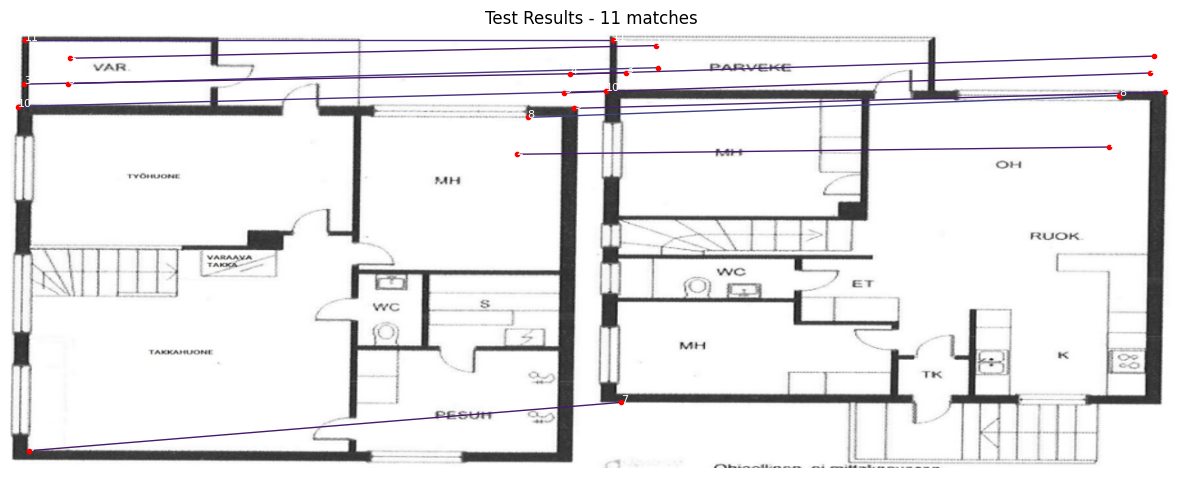


Transformation estimée avec top-10 matches (3 inliers, ratio=0.30) :
[[ 9.95033805e-01  1.25671788e-02  5.92975144e+00]
 [-1.25671788e-02  9.95033805e-01 -1.29450079e+01]]

Nombre de correspondances utilisées pour l'estimation : 10 (top-10)

Matrice 2×3 estimée (rotation, échelle, translation) :
 [[ 9.95033805e-01  1.25671788e-02  5.92975144e+00]
 [-1.25671788e-02  9.95033805e-01 -1.29450079e+01]]


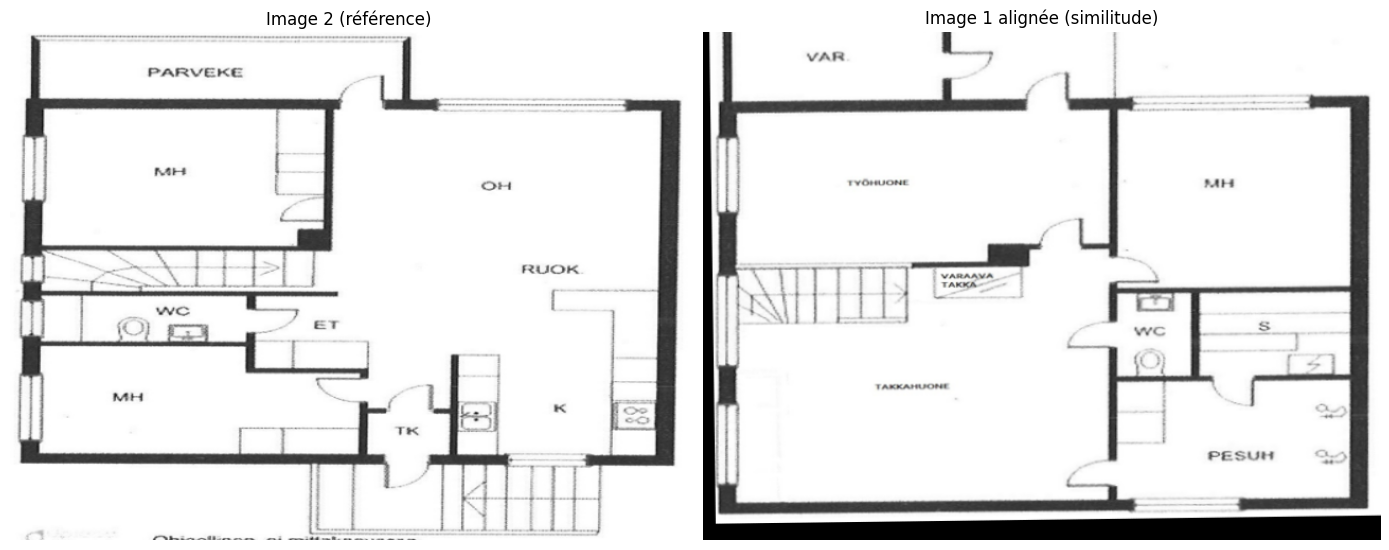


Statistiques:
Nombre de keypoints image 1: 1024
Nombre de keypoints image 2: 1024
Nombre de matches valides: 11
Score moyen des matches: 0.0025


In [10]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml

def load_image(path):
    """Charge et prétraite une image"""
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 480))
    image = torch.from_numpy(image).float().permute(2, 0, 1)[None] / 255.
    return image

def plot_matches(image1, image2, kpts1, kpts2, matches, scores, title="Matches", n_matches=10):
    #Affiche les n meilleures correspondances entre deux images
    image1 = image1.squeeze().permute(1,2,0).cpu().numpy()
    image2 = image2.squeeze().permute(1,2,0).cpu().numpy()
    kpts1 = kpts1.cpu().numpy()
    kpts2 = kpts2.cpu().numpy()
    matches = matches.cpu().numpy()
    scores = scores.cpu().numpy()

    H1, W1 = image1.shape[:2]
    H2, W2 = image2.shape[:2]
    H = max(H1, H2)
    W = W1 + W2
    combined = np.zeros((H, W, 3))
    combined[:H1, :W1] = image1
    combined[:H2, W1:] = image2

    plt.figure(figsize=(15, 8))
    plt.imshow(combined)
   
    # Filtrer les matches valides et prendre les n meilleurs
    valid = matches > -1
    valid_scores = scores[valid]
    valid_idx = valid.nonzero()[0]
   
    if len(valid_scores) > n_matches:
        # Prendre les n meilleurs scores
        best_idx = np.argsort(valid_scores)[-n_matches:]
        selected_idx = valid_idx[best_idx]
    else:
        selected_idx = valid_idx
   
    # Tracer uniquement les correspondances sélectionnées
    for idx in selected_idx:
        p1 = kpts1[idx]
        p2 = kpts2[matches[idx]]
        color = plt.cm.viridis(scores[idx])
        plt.plot([p1[0], p2[0] + W1], [p1[1], p2[1]], c=color, linewidth=1)
        # Option: ajouter des numéros aux points
        plt.text(p1[0], p1[1], f'{len(selected_idx)-np.where(selected_idx==idx)[0][0]}',
                color='white', fontsize=8)
        plt.text(p2[0] + W1, p2[1], f'{len(selected_idx)-np.where(selected_idx==idx)[0][0]}',
                color='white', fontsize=8)
    print(f"{valid.sum()} matches valides avant filtrage")  #######################################
    plt.plot(kpts1[selected_idx, 0], kpts1[selected_idx, 1], 'r.')
    plt.plot(kpts2[matches[selected_idx], 0] + W1, kpts2[matches[selected_idx], 1], 'r.')
    plt.title(f"{title} - {len(selected_idx)} matches")
    plt.axis('off')
    plt.show()
"""
def plot_matches(image1, image2, kpts1, kpts2, matches, scores, title="All Matches"):
    #Affiche toutes les correspondances valides
    image1 = image1.squeeze().permute(1, 2, 0).cpu().numpy()
    image2 = image2.squeeze().permute(1, 2, 0).cpu().numpy()
    kpts1 = kpts1.cpu().numpy()
    kpts2 = kpts2.cpu().numpy()
    matches = matches.cpu().numpy()
    scores = scores.cpu().numpy()

    H1, W1 = image1.shape[:2]
    H2, W2 = image2.shape[:2]
    H = max(H1, H2)
    W = W1 + W2
    combined = np.zeros((H, W, 3))
    combined[:H1, :W1] = image1
    combined[:H2, W1:] = image2

    plt.figure(figsize=(15, 8))
    plt.imshow(combined)

    valid = matches > -1
    valid_idx = np.where(valid)[0]

    for idx in valid_idx:
        p1 = kpts1[idx]
        p2 = kpts2[matches[idx]]
        color = plt.cm.viridis(scores[idx])  # Couleur selon score
        plt.plot([p1[0], p2[0] + W1], [p1[1], p2[1]], c=color, linewidth=1)

    plt.plot(kpts1[valid_idx, 0], kpts1[valid_idx, 1], 'r.', markersize=2)
    plt.plot(kpts2[matches[valid_idx], 0] + W1, kpts2[matches[valid_idx], 1], 'r.', markersize=2)

    plt.title(f"{title} - {len(valid_idx)} correspondances")
    plt.axis('off')
    plt.show()
"""

def test_pair(image_path1, image_path2, extractor, matcher, device):
    """Teste une paire d'images avec les modèles entraînés"""
    # Charger les images
    image1 = load_image(image_path1).to(device)
    image2 = load_image(image_path2).to(device)
   
    # Passer en mode évaluation
    extractor.eval()
    matcher.eval()
   
    with torch.no_grad():
        # Extraire les features avec SuperPoint
        pred1 = extractor({"image": image1})
        pred2 = extractor({"image": image2})
       
        # Préparer les données pour LightGlue avec la structure correcte
        data = {
            "image0": image1,
            "image1": image2,
            "keypoints0": pred1["keypoints"],
            "keypoints1": pred2["keypoints"],
            "descriptors0": pred1["descriptors"],
            "descriptors1": pred2["descriptors"],
            #"keypoint_scores0": pred1["scores"],  
            #"keypoint_scores1": pred2["scores"],
            "view0": {"image_size": image1.shape[-2:]},  # Correction ici
            "view1": {"image_size": image2.shape[-2:]},  # Correction ici
        }
        # Forcer le filtre à zéro
        #matcher.config.filter_threshold = 0.001
        # Faire le matching avec LightGlue
        matches = matcher(data)
       
        # Afficher les résultats
        plot_matches(
            image1, image2,
            pred1["keypoints"][0],
            pred2["keypoints"][0],
            matches["matches0"][0],
            matches["matching_scores0"][0],
            "Test Results",
            n_matches=40 
        )
       
        #############################################################################################################
        # === 1. Récupération des 10 meilleures correspondances valides ===
        kpts1 = pred1["keypoints"][0].cpu().numpy()
        kpts2 = pred2["keypoints"][0].cpu().numpy()
        matches0 = matches["matches0"][0].cpu().numpy()
        scores0 = matches["matching_scores0"][0].cpu().numpy()

        valid_idx = np.where(matches0 > -1)[0]
        if len(valid_idx) < 4:
            print("Pas assez de correspondances valides pour estimer une transformation.")
            return


################################################################################################

        sorted_idx = valid_idx[np.argsort(-scores0[valid_idx])]

        best_M, best_inliers, best_k = None, None, 0
        max_inliers = -1
        best_ratio = 0.0

        # Parcourir plusieurs top_k
        for top_k in range(10, min(len(sorted_idx), 150)+1, 10):
            top_idx = sorted_idx[:top_k]
            pts1_try = kpts1[top_idx]
            pts2_try = kpts2[matches0[top_idx]]

            if len(pts1_try) < 3:
                continue

            M_try, inliers_try = cv2.estimateAffinePartial2D(
                pts1_try, pts2_try,
                method=cv2.RANSAC,
                ransacReprojThreshold=3.0,
                maxIters=2000,
                confidence=0.99,
                refineIters=50,
            )

            if M_try is not None and inliers_try is not None:
                inlier_count = inliers_try.sum()
                inlier_ratio = inlier_count / top_k

                # ⇨ On accepte si meilleur score ET assez d'inliers par rapport au total
                if inlier_count > max_inliers and inlier_ratio >= 0.2:
                    best_M, best_inliers = M_try, inliers_try
                    max_inliers = inlier_count
                    best_k = top_k
                    best_ratio = inlier_ratio

        if best_M is None:
            print("Échec de l'estimation de transformation.")
            return

        # Pour affichage
        top_idx = sorted_idx[:best_k]
        pts1 = kpts1[top_idx]
        pts2 = kpts2[matches0[top_idx]]

        print(f"\nTransformation estimée avec top-{best_k} matches "f"({max_inliers} inliers, ratio={best_ratio:.2f}) :\n{best_M}")
        M = best_M  # pour les étapes suivantes


################################################################################################
        # Trier les indices valides par score décroissant
        #sorted_idx = valid_idx[np.argsort(-scores0[valid_idx])]
        #top_k = 40
        #top_idx = sorted_idx[:top_k]  # Prendre les k meilleurs

        #pts1 = kpts1[top_idx]
        #pts2 = kpts2[matches0[top_idx]]

        print(f"\nNombre de correspondances utilisées pour l'estimation : {len(pts1)} (top-{top_k})")

                # === 2. Estimation de la transformation homographique ===
        # === 2. Estimation de la transformation 2-D (similitude / affine) ===
        if len(pts1) >= 3:            # 3 points suffisent pour le modèle 2×3
            # RANSAC + modèle partiel (rotation + translation + échelle, pas de cisail.)
            M, inliers = cv2.estimateAffinePartial2D(
                pts1, pts2,
                method=cv2.RANSAC,
                ransacReprojThreshold=3.0,
                maxIters=2000,
                confidence=0.99,
                refineIters=50,
                # fullAffine=False  # par défaut → similitude / affine restreinte
            )

            if M is None:
                print("L'estimation a échoué.")
                return

            print("\nMatrice 2×3 estimée (rotation, échelle, translation) :\n", M)

            # === 3. Warp (2-D) pour vérification ===
            h, w = image2.shape[-2:]
            warped_img1 = cv2.warpAffine(
                (image1[0].permute(1, 2, 0).cpu().numpy()*255).astype(np.uint8),
                M, (w, h)
            )

            # Affichage
            fig, axs = plt.subplots(1, 2, figsize=(14, 6))
            axs[0].imshow(image2.squeeze().permute(1, 2, 0).cpu().numpy())
            axs[0].set_title("Image 2 (référence)")
            axs[0].axis('off')

            axs[1].imshow(warped_img1)
            axs[1].set_title("Image 1 alignée (similitude)")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("Pas assez de correspondances pour estimer la transformation.")

        #############################################################################################################
        #plot_matches(
        #    image1, image2,
        #    pred1["keypoints"][0],
        #    pred2["keypoints"][0],
        #    matches["matches0"][0],
        #    matches["matching_scores0"][0],
        #    "Toutes les correspondances"
        #)
        # Afficher les statistiques
        valid_matches = (matches["matches0"][0] != -1).sum().item()
        print(f"\nStatistiques:")
        print(f"Nombre de keypoints image 1: {pred1['keypoints'].shape[1]}")
        print(f"Nombre de keypoints image 2: {pred2['keypoints'].shape[1]}")
        print(f"Nombre de matches valides: {valid_matches}")
        print(f"Score moyen des matches: {matches['matching_scores0'].mean().item():.4f}")

if __name__ == "__main__":
    # Configuration du device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation de: {device}")

    # Charger la configuration
    with open("configs/superpoint+lightglue_Mydataset.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Initialiser les modèles
    extractor = SuperPoint(config["model"]["extractor"]).eval().to(device)
    matcher = LightGlue(config["model"]["matcher"]).eval().to(device)

    # Charger les poids fine-tunés
    #checkpoint = torch.load('best_model.pth', map_location=device)
    #extractor.load_state_dict(checkpoint['extractor_state_dict'])
    #matcher.load_state_dict(checkpoint['matcher_state_dict'])

    extractor.load_state_dict(torch.load(r"C:\Users\STAGE2025\Downloads\superpoint_v1.pth", map_location=device))  #r"C:\Users\STAGE2025\Downloads\superpoint_v1.pth"
    matcher.load_state_dict(torch.load("trained_models/lightglue.pth", map_location=device))
    print("Modèles chargés avec succès")

    # Chemins des images de test
    image_path1 = r"C:\Users\STAGE2025\Matching_LightGlue\gluefactory\datasets\organized_dataset\Undistorted_SfM\pair1\images\pair1_img0.png"
    image_path2 = r"C:\Users\STAGE2025\Matching_LightGlue\gluefactory\datasets\organized_dataset\Undistorted_SfM\pair1\images\pair1_img1.png"
   
    # Tester la paire d'images
    print("\nDébut du test...")
    test_pair(image_path1, image_path2, extractor, matcher, device)